In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from natsort import natsorted
import earthpy.spatial as es
import pandas as pd
import geopandas
import rasterio
import pycrs
import os

file_dir=r'C:/Users/M-RAM/PycharmProjects/InternshipNaturalis/github_trait_geo_diverse_dl/trait-geo-diverse-dl'

Can't load requested DLL: C:\Program Files (x86)\GDAL\gdalplugins\gdal_BAG.dll
193: %1 is not a valid Win32 application.

Can't load requested DLL: C:\Program Files (x86)\GDAL\gdalplugins\gdal_BAG.dll
193: %1 is not a valid Win32 application.

Can't load requested DLL: C:\Program Files (x86)\GDAL\gdalplugins\gdal_FITS.dll
193: %1 is not a valid Win32 application.

Can't load requested DLL: C:\Program Files (x86)\GDAL\gdalplugins\gdal_FITS.dll
193: %1 is not a valid Win32 application.

Can't load requested DLL: C:\Program Files (x86)\GDAL\gdalplugins\gdal_GMT.dll
193: %1 is not a valid Win32 application.

Can't load requested DLL: C:\Program Files (x86)\GDAL\gdalplugins\gdal_GMT.dll
193: %1 is not a valid Win32 application.

Can't load requested DLL: C:\Program Files (x86)\GDAL\gdalplugins\gdal_HDF4.dll
193: %1 is not a valid Win32 application.

Can't load requested DLL: C:\Program Files (x86)\GDAL\gdalplugins\gdal_HDF4.dll
193: %1 is not a valid Win32 application.

Can't load requested

build dictionary

In [4]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/spec_filtered/taxa.txt",header=None)
taxa.columns=["taxon"]

In [5]:
species_occ_dict={}

for i in taxa["taxon"]:
    taxon_data = pd.read_csv(file_dir+"/data/spec_filtered/%s.csv"%i)
    #add species dataframe to dict
    species_occ_dict["%s"%i] = taxon_data  
    #check whether all species have been included and inspect dictionary
if len(species_occ_dict.keys())==len(taxa["taxon"]):
    print("All species dataframes now in dictionary")
else:
    print("Error: not all species dataframe included")

All species dataframes now in dictionary


#### Part 1
- First read in occurrence data for Capreolus capreolus
- Create a copy that we can use in the original state later
- Create a buffer around each occurrence point, merge it into a single polygon
- Clip the environmental raster based on this extend

In [136]:
#load occurrence data 
data=species_occ_dict["Capreolus_capreolus"]
spec = "Capreolus_capreolus"


data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
data['coordinates'] = data["coordinates"].apply(Point)
data["present/pseudo_absent"]=1
geo_data=geopandas.GeoDataFrame(data, geometry='coordinates',crs={'init' :'epsg:4326'})
    
#change projection to azimuthal equidistant to calculate 1000km buffer around point
geo_data = geo_data.to_crs({'init': 'esri:54032'}) 
buffer=geo_data.buffer(1000*1000)
buffer=buffer.to_crs(epsg=4326)

#create single large polygon from individual buffers
union_buffer=buffer.unary_union

#first clip the raster based on this extend 
raster=rasterio.open(r'C:/Users/M-RAM/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
#specify output tif:
out_tif = r'C:/Users/M-RAM/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec

#clip the raster:
out_img, out_transform = mask(dataset=raster, shapes=[union_buffer],crop=True)

# Copy the metadata
out_meta = raster.meta.copy()

# Parse EPSG code
epsg_code = int(raster.crs.data['init'][5:])
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

#### Part 2
- now that we have the clipped raster we can use it to try and make a random selection of pseudo absence points
- we first open the raster
- then we separate those cells that actually contain pixel values (excluding the sea)
- we calculate the longitude and latitude of the centre point of these cells <br>
  (the environmental variable values do not vary within each cell so it doesn't matter if each points is in the centre)
- we make a random selection of 10.0000 positions
- we add the longitude and latitude values of these to to the dataset and export it  

In [12]:
from osgeo import gdal
import numpy as np

#load occurrence data 
data=species_occ_dict["Capreolus_capreolus"]
spec = "Capreolus_capreolus"

r = gdal.Open(r'C:/Users/M-RAM/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
band = r.GetRasterBand(1) #bands start at one
a = band.ReadAsArray().astype(np.float)

(y_index, x_index) = np.nonzero(a > -1000)
(upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point

lon_lat_array=np.stack((x_coords,y_coords)).T

random_sample_lon_lats=lon_lat_array[np.random.choice(lon_lat_array.shape[0], 10000, replace=False), :]

lon=[]
lat=[]
psa=[0]*10000
taxon=["%s"%spec]*10000
gbif=["no_id"]*10000

for item in random_sample_lon_lats:
    longitude=item[0]
    latitude=item[1]
    lon.append(longitude)
    lat.append(latitude)
    
###Dataset including 10.000 pseudo-absence points for capriolus capriolus
new_data=pd.DataFrame({"gbif_id": gbif,"taxon_name":taxon,"decimal_longitude": lon, "decimal_latitude":lat, "present/pseudo_absent": psa})
data=pd.concat([data,new_data],ignore_index=True)
data=data[['taxon_name','gbif_id','decimal_longitude','decimal_latitude','present/pseudo_absent']]
data.to_csv(file_dir + "/data/capriolus_trial/Capriolus_capriolus_occ_dataframe.csv")

###Dataset including all locations with data-values (to later predict presence-pseudoabsence on)
lon=[]
lat=[]

for item in lon_lat_array:
    longitude=item[0]
    latitude=item[1]
    lon.append(longitude)
    lat.append(latitude)

taxon=["%s"%spec]*len(lon)

data_to_pred=pd.DataFrame({"taxon_name":taxon, "decimal_longitude":lon,"decimal_latitude":lat})
data_to_pred.to_csv(file_dir + "/data/capriolus_trial/Capriolus_capriolus_location_to_predict.csv")

#data2["decimal_longitude"]=pd.concat(lon
#data2["decimal_latitude"]=lat
#data2["present/pseudo_absent"]=0


C:\Users\M-RAM\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:35: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [13]:
data_pred=pd.read_csv(file_dir + "/data/capriolus_trial/Capriolus_capriolus_location_to_predict.csv")
data_pred

,Unnamed: 0,taxon_name,decimal_longitude,decimal_latitude
0,0,Capreolus_capreolus,18.791667,70.125000
1,1,Capreolus_capreolus,19.041667,70.125000
2,2,Capreolus_capreolus,19.125000,70.125000
3,3,Capreolus_capreolus,19.375000,70.125000
4,4,Capreolus_capreolus,19.458333,70.125000
5,5,Capreolus_capreolus,19.791667,70.125000
6,6,Capreolus_capreolus,19.875000,70.125000
7,7,Capreolus_capreolus,20.625000,70.125000
8,8,Capreolus_capreolus,20.708333,70.125000
9,9,Capreolus_capreolus,18.791667,70.041667


In [139]:
#check result
data=pd.read_csv(file_dir + "/data/capriolus_trial/Capriolus_capriolus_occ_dataframe.csv")
data

,Unnamed: 0,taxon_name,gbif_id,decimal_longitude,decimal_latitude,present/pseudo_absent
0,0,Capreolus capreolus,1700785217,-2.457180,53.611330,1
1,1,Capreolus capreolus,1531382573,1.192960,52.869500,1
2,2,Capreolus capreolus,1548517864,-2.826710,51.331670,1
3,3,Capreolus capreolus,1558908279,-3.498220,56.409520,1
4,4,Capreolus capreolus,1562609906,-3.953940,54.963900,1
5,5,Capreolus capreolus,1529474958,-1.532040,50.835040,1
6,6,Capreolus capreolus,1529523046,-5.760000,57.529030,1
7,7,Capreolus capreolus,1700634083,-3.737750,57.235320,1
8,8,Capreolus capreolus,1700619901,-3.616370,57.187530,1
9,9,Capreolus capreolus,1700630872,-3.989120,57.070710,1


#### Part 3
- Now we have to extract the environmental variable values for all the points in the dataset

In [140]:
#read in data
data = pd.read_csv(file_dir + "/data/capriolus_trial/Capriolus_capriolus_occ_dataframe.csv")
spec = data["taxon_name"][0]
spec = spec.replace(" ","_")
# extract longitude and latitude and store them in normal list (as opposed to pandas Series)
lon = data["decimal_longitude"]
lat = data["decimal_latitude"]
lat = pd.Series.tolist(lat)
lon = pd.Series.tolist(lon)
#print("processing species %s" % spec)

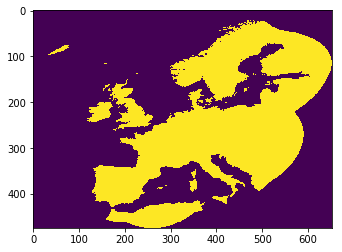

In [144]:
#read in raster
src = rasterio.open(r'C:/Users/M-RAM/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
show(src.read(1))

In [146]:
# go through bands iteratively
for i in range(1, 42):
    array = src.read(i)
    band_name = "band %s" % i
    data[band_name] = None
    print("processing band %s" % i)
    for j in range(0, len(data)):
        print("processing observation %s"%j)
        # What is the corresponding row and column in our image?
        row, col = src.index(lon[j], lat[j])  # spatial --> image coordinates
        # print(f'row,col=\t\t({row},{col})')
        # What is the value?
        value = array[row, col]
        data[band_name][j] = value
data.to_csv(file_dir + "/data/capriolus_trial/Capriolus_capriolus_env_dataframe.csv" % spec)

processing band 1
processing observation 0


C:\Users\M-RAM\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


processing observation 1
processing observation 2
processing observation 3
processing observation 4
processing observation 5
processing observation 6
processing observation 7
processing observation 8


KeyboardInterrupt: 